In [2]:
import numpy as np
import pandas as pd
df = pd.read_csv('final_train_data.csv')

train_labels = df['label']
train_labels = np.array(train_labels)
print(train_labels)

train_features = df.iloc[:,:22]
train_features = np.array(train_features)
print(train_features)

print('train_features', train_features.shape)
print('train_labels', train_labels.shape)

df = pd.read_csv('final_test_data.csv')

test_labels = df['label']
test_labels = np.array(test_labels)
print(test_labels)

test_features = df.iloc[:,:22]
test_features = np.array(test_features)
print(test_features)

print('test_features', test_features.shape)
print('test_labels', test_labels.shape)

[0 0 0 ... 9 9 9]
[[ 0.5         0.          0.         ... -2.25026198  1.05389037
   0.25220342]
 [ 0.5         0.          0.         ... -2.45748523  0.59133094
   1.17606856]
 [ 0.5         0.          0.         ... -3.59455636  1.5385524
   1.02601294]
 ...
 [ 0.5         0.16666667  0.2        ...  0.3597699   1.8395691
   0.5189403 ]
 [ 0.5         0.16666667  0.2        ...  0.28965998  0.45773501
   1.8070799 ]
 [ 0.5         0.16666667  0.2        ...  2.38745817  0.48869032
  -1.2715561 ]]
train_features (1280, 22)
train_labels (1280,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 

In [3]:
# 导入包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from vecstack import stacking
from sklearn.model_selection import GridSearchCV,ParameterGrid
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import warnings

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
warnings.filterwarnings('ignore')


In [4]:
#获取准确率最高的rel_knn_algorithm、rel_weight和rel_nearest_neighbor
from sklearn import neighbors,decomposition
rel_nearest_neighbor = 0
rel_knn_algorithm = ''
rel_weight = ''
knn_algorithms = ['ball_tree', 'kd_tree', 'brute']
weights = ['uniform', 'distance']
rel_pre = -1

for knn_algorithm in knn_algorithms:
    #nearest_neighbor参数范围为1-200
    for nearest_neighbor in range(1,101):
        for weight in weights:
            clf = neighbors.KNeighborsClassifier(n_neighbors = nearest_neighbor, weights=weight, algorithm=knn_algorithm)
            clf = clf.fit(train_features, train_labels)

            pre = clf.predict(test_features)
            accuracy = np.sum(pre == test_labels) / pre.shape[0]
            #print('knn_algorithm =',knn_algorithm,',nearest_neighbors =', nearest_neighbor,',weight =',weight,  ',accuracy=', accuracy)
            if accuracy >= rel_pre:
                rel_pre = accuracy
                rel_knn_algorithm =knn_algorithm
                rel_weight = weight
                rel_nearest_neighbor = nearest_neighbor

print('rel_knn_algorithm：',rel_knn_algorithm)
print('rel_weight：',rel_weight)
print('rel_nearest_neighbor：',rel_nearest_neighbor)
from sklearn import neighbors,decomposition
knn_cv = neighbors.KNeighborsClassifier(n_neighbors = rel_nearest_neighbor, weights=rel_weight,
                                     algorithm=rel_knn_algorithm)

rel_knn_algorithm： brute
rel_weight： uniform
rel_nearest_neighbor： 15


In [5]:
from sklearn import tree
rel_max_depth = 0
rel_min_samples_leaf = 0
rel_pre = -1

for max_depth in range(train_features.shape[1],2, -1):
    for min_samples_leaf in range(1,int(2000 * 0.1),2):
        clf = tree.DecisionTreeClassifier(max_depth = max_depth,min_samples_leaf =min_samples_leaf)
        clf = clf.fit(train_features, train_labels)

        pre = clf.predict(test_features)
        accuracy = np.sum(pre == test_labels) / pre.shape[0]
#        print('max_depth =',max_depth,',min_samples_leaf =', min_samples_leaf,'accuracy=', accuracy)
        if accuracy >= rel_pre:
            rel_pre = accuracy
            rel_max_depth =max_depth
            rel_min_samples_leaf = min_samples_leaf
print('rel_pre：',rel_pre)
print('rel_max_depth：',rel_max_depth)
print('rel_min_samples_leaf：',rel_min_samples_leaf)
dt_cv = tree.DecisionTreeClassifier(max_depth = rel_max_depth,min_samples_leaf =rel_min_samples_leaf)

rel_pre： 0.90625
rel_max_depth： 4
rel_min_samples_leaf： 121


In [6]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB
# 创建分类器对象
clf = GaussianNB()
#用训练数据拟合分类器模型
nb_sv = clf.fit(train_features.astype(np.float64), train_labels)

In [7]:
# 模型融合
model_list = [knn_cv,dt_cv,nb_sv]
rel_n_folds = 0
rel_pre = -1
x = []
y = []

for n_fold in range(2,101, 1):
    S_train, S_test = stacking(model_list, train_features, train_labels,test_features, regression=False, n_folds=n_fold)
    # # Initialize 2-nd level model
    model = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100, max_depth = 1)
    # # Fit 2-nd level model
    model_s = model.fit(S_train, train_labels)
    # # Predict
    y_pred = model_s.predict(S_test)
    # Final prediction score
    f1_score = metrics.f1_score(y_pred, test_labels,average="micro")
    x.append(n_fold)
    y.append(f1_score)
    print('n_folds =',n_fold,'f1_score=', f1_score)
    if f1_score >= rel_pre:
        rel_pre = f1_score
        rel_n_folds = n_fold
    
# acc_score_test = metrics.accuracy_score(y_pred, test_labels)
# precision_score_test = metrics.precision_score(y_pred, test_labels, average="micro")
# recall_score_test = metrics.recall_score(y_pred, test_labels, average="micro")
# f1_score_test = metrics.f1_score(y_pred, test_labels, average="micro")

# # scoring='roc_auc'是用来检测定性数据结果的，比如好人坏人，是和否等，即结果为0或1的数据预测
# # roc_auc_score_test = metrics.roc_auc_score(y_pred, test_labels,average="micro")

# print('Final 测试集准确率：{}\n'.format(acc_score_test))
# print('Final 测试集精确率：{}\n'.format(precision_score_test))
# print('Final 测试集召回率：{}\n'.format(recall_score_test))
# print('Final 测试集f1评分：{}\n'.format(f1_score_test))
# print('Final 测试集AUC值：{}\n'.format(roc_auc_score_test))
        
        
# model_est(model_dict_s, x_train, x_test, y_train, y_test) 



n_folds = 2 f1_score= 0.46875
n_folds = 3 f1_score= 0.215625
n_folds = 4 f1_score= 0.228125
n_folds = 5 f1_score= 0.028125
n_folds = 6 f1_score= 0.215625
n_folds = 7 f1_score= 0.228125
n_folds = 8 f1_score= 0.371875
n_folds = 9 f1_score= 0.65625
n_folds = 10 f1_score= 0.028125
n_folds = 11 f1_score= 0.9125
n_folds = 12 f1_score= 0.8375
n_folds = 13 f1_score= 0.9375
n_folds = 14 f1_score= 0.8625
n_folds = 15 f1_score= 0.91875
n_folds = 16 f1_score= 0.828125
n_folds = 17 f1_score= 0.8625
n_folds = 18 f1_score= 0.94375
n_folds = 19 f1_score= 0.8625
n_folds = 20 f1_score= 0.853125
n_folds = 21 f1_score= 0.946875
n_folds = 22 f1_score= 0.9375
n_folds = 23 f1_score= 0.83125
n_folds = 24 f1_score= 0.834375
n_folds = 25 f1_score= 0.91875
n_folds = 26 f1_score= 0.946875
n_folds = 27 f1_score= 0.8625
n_folds = 28 f1_score= 0.91875
n_folds = 29 f1_score= 0.9375
n_folds = 30 f1_score= 0.94375
n_folds = 31 f1_score= 0.9500000000000001
n_folds = 32 f1_score= 0.94375
n_folds = 33 f1_score= 0.95000000

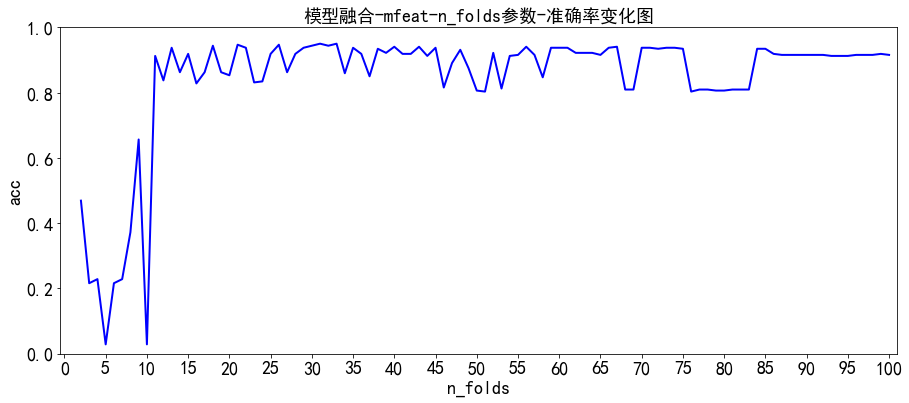

In [13]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from pylab import *                                 #支持中文
mpl.rcParams['font.sans-serif'] = ['SimHei']

#X轴，Y轴数据
# x = [0,1,2,3,4,5,6]
# y = [0.3,0.4,2,5,3,4.5,4]
plt.figure(figsize=(15,6)) #创建绘图对象
plt.plot(x,y,"b",linewidth=2)   #在当前绘图对象绘图（X轴，Y轴，蓝色虚线，线宽度）
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel("n_folds",size=18) #X轴标签
plt.ylabel("acc",size=18)  #Y轴标签
plt.title("模型融合-mfeat-n_folds参数-准确率变化图",size=18) #图标题
# 设置数字标签
# for a, b in zip(x, y):
#     plt.text(a, b, b, ha='center', va='bottom')

from matplotlib.pyplot import MultipleLocator    
x_major_locator=MultipleLocator(5)
#把x轴的刻度间隔设置为1，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.xaxis.set_major_locator(x_major_locator)
plt.xlim(-0.5,101)
plt.ylim(0,1)

plt.savefig("模型融合-mfeat-n_folds参数选择图（final）.png") #保存图
plt.show()  #显示图

In [9]:
print(rel_pre)

0.9500000000000001
